# Coursera Captsone Final Project 

###### Importing necessary libraries

In [1]:
#import necessary libraries
from bs4 import BeautifulSoup
from urllib.request import urlopen
import lxml
import requests
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge folium=0.5.0 --yes
import folium

import matplotlib.pyplot as plt

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  11.04 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  34.85 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  39.11 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  46.43 MB/s


## Step 1: Getting gelocation data for New York City (for Bronx and Brooklyn)

**Using JSON file containing data and using it to create Pandas dataframe**

### Getting dataframe with NewYork neighbourhood and geolocation data

In [2]:
#Download data from the link
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

#Loading JSON data into object/variable to use
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
#Exploring structure
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

Data downloaded!


{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

**Getting dataframe from object containing JSON data**

In [3]:
#define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the empty dataframe with desired columns
df_nyc = pd.DataFrame(columns=column_names)
df_nyc

,Borough,Neighbourhood,Latitude,Longitude


In [4]:
#loop through onject file to fill empty datafranmw we just created

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_nyc = df_nyc.append({'Borough': borough,
                                          'Neighbourhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
df_nyc.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


**Filter for rows where Borough is Bronx or Brooklyn**

In [5]:
df_Bro = df_nyc[df_nyc['Borough'] == 'Brooklyn'].reset_index(drop=True) #only taking data for neighbourhoods in Brooklyn
df_Bro = df_Bro.append(df_nyc[df_nyc['Borough'] == 'Bronx'])  # adding data for Bronx

print(df_Bro.shape)
df_Bro.head()

(122, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


#### Vizualizing neighbourhoods on map

In [6]:
# create map

address = 'Manhattan, New Work'   #using Manhattan to center map for boroughs north and south of manhattan
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_lat = location.latitude
ny_lon = location.longitude


map_clusters_nyc = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)


# add markers to the map
markers_colors = []
for lat, lon, poi in zip(df_Bro['Latitude'], df_Bro['Longitude'], df_Bro['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

## Step 2: Getting venues data from FourSquare

### 2A. FourSquare Credentialing and creating function to be used later

In [7]:
#sample code for credentialing, actual code hidden below

CLIENT_ID = 'Your Cliend Id' # your Foursquare ID
CLIENT_SECRET = 'Your Cliend secret' # your Foursquare Secret
VERSION = 'version' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Your Cliend Id
CLIENT_SECRET:Your Cliend secret


In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
# creating a function to use this with multiple neighbourhoods

LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, boroughs, radius=500):
    
    venues_list=[]
    for name, lat, lng, bor in zip(names, latitudes, longitudes, boroughs):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue # appending values retrived from JSON
        venues_list.append([(
            name, 
            lat, 
            lng, 
            bor,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 'Borough',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### 2B. Using function on neighbourhoods in two boroughs and getting venues data for neighbourhoods

In [10]:
nyc_venues = getNearbyVenues(names=df_Bro['Neighbourhood'],
                                   latitudes=df_Bro['Latitude'],
                                   longitudes=df_Bro['Longitude'],
                                     boroughs=df_Bro['Borough'])

# check shape and first 5 rows of column

print(nyc_venues.shape)

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus
Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway

In [59]:
nyc_venues.head(10)  #dataframe is a consist of venues retunred by API and function created

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Brooklyn,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Brooklyn,Cocoa Grinder,40.623967,-74.030863,Juice Bar
2,Bay Ridge,40.625801,-74.030621,Brooklyn,Bagel Boy,40.627896,-74.029335,Bagel Shop
3,Bay Ridge,40.625801,-74.030621,Brooklyn,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Brooklyn,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place
5,Bay Ridge,40.625801,-74.030621,Brooklyn,XIN,40.625082,-74.030494,Chinese Restaurant
6,Bay Ridge,40.625801,-74.030621,Brooklyn,Leo's Casa Calamari,40.623348,-74.031082,Pizza Place
7,Bay Ridge,40.625801,-74.030621,Brooklyn,Brooklyn Market,40.626939,-74.029948,Grocery Store
8,Bay Ridge,40.625801,-74.030621,Brooklyn,Karam,40.622931,-74.028316,Middle Eastern Restaurant
9,Bay Ridge,40.625801,-74.030621,Brooklyn,A.L.C. Italian Grocery,40.623051,-74.031224,Grocery Store


**Histogram of how many venues nighbourhoods have (as returned by FourSquare API)**

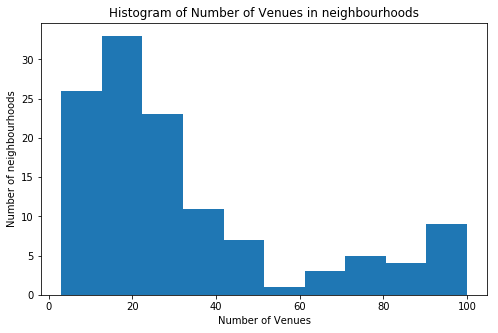

In [12]:
counts = nyc_venues.groupby('Neighbourhood').count()  #storing count from one column to a new dataframe

counts['Venue'].plot(kind='hist', figsize=(8, 5))
plt.title('Histogram of Number of Venues in neighbourhoods') # add a title to the histogram
plt.ylabel('Number of neighbourhoods') # add y-label
plt.xlabel('Number of Venues') # add x-label

plt.show()

### 2C. Data Cleaning and Feature Engineering to make data ready for KNN

In [13]:
# one hot encoding catagories to better be able to use K-means - feature engineering
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighbourhood'] = nyc_venues['Neighbourhood'] 



# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

print(nyc_onehot.shape)
nyc_onehot.head()

(4026, 314)


,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# group by nightbourhoods to see how many venues catagories in different neighbourhoods

nyc_grouped = nyc_onehot.groupby('Neighbourhood').mean().reset_index()

borough = df_Bro.iloc[:, 0:2]

nyc_grouped = pd.merge(nyc_grouped, borough, how='outer')

print(nyc_grouped.shape)

nyc_grouped

(122, 315)


<bound method NDFrame.head of                  Neighbourhood  Accessories Store  Adult Boutique  \
0                     Allerton           0.000000             0.0   
1                   Bath Beach           0.000000             0.0   
2                    Bay Ridge           0.000000             0.0   
3                   Baychester           0.000000             0.0   
4                 Bedford Park           0.000000             0.0   
5           Bedford Stuyvesant           0.000000             0.0   
6                      Belmont           0.000000             0.0   
7                  Bensonhurst           0.000000             0.0   
8                 Bergen Beach           0.000000             0.0   
9                  Boerum Hill           0.000000             0.0   
10                Borough Park           0.000000             0.0   
11              Brighton Beach           0.000000             0.0   
12           Broadway Junction           0.000000             0.0   
13  

### Some cleaning

In [15]:
nyc_grouped.dropna(inplace=True)  #dropping a few records with NaN values
nyc_grouped.head(10)
#nyc_grouped['Borough']

,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Borough
0,Allerton,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Bronx
1,Bath Beach,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.039216,0.000000,Brooklyn
2,Bay Ridge,0.0,0.0,0.0,0.0,0.034483,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Brooklyn
3,Baychester,0.0,0.0,0.0,0.0,0.052632,0.000000,0.052632,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Bronx
4,Bedford Park,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Bronx
5,Bedford Stuyvesant,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.037037,0.037037,0.000000,0.000000,0.000000,Brooklyn
6,Belmont,0.0,0.0,0.0,0.0,0.021053,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.010526,0.000000,0.000000,Bronx
7,Bensonhurst,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Brooklyn
8,Bergen Beach,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Brooklyn
9,Boerum Hill,0.0,0.0,0.0,0.0,0.012346,0.012346,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.012346,0.000000,0.000000,0.024691,Brooklyn


In [64]:
city = nyc_grouped['Borough']   #creating object containing city column 
neigh = nyc_grouped['Neighbourhood'] #creating object containing neighbourhood column
nyc_grouped.drop(labels = ['Borough', 'Neighbourhood'], axis=1, inplace=True)
nyc_grouped = nyc_grouped.astype('float64')  #converting all columns (except for Borough and Neighbourhood) to float for knn to avoid object type error
nyc_grouped.insert(0,'Neighbourhood', neigh) #inserting back neighbourhood
nyc_grouped.insert(1,'Borough', city) #inserting back borough
nyc_grouped.head()

,Neighbourhood,Borough,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Has Ice Cream Shops?
0,Allerton,Bronx,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Bath Beach,Brooklyn,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039216,0.0,1.0
2,Bay Ridge,Brooklyn,0.0,0.0,0.0,0.0,0.034483,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0
3,Baychester,Bronx,0.0,0.0,0.0,0.0,0.052632,0.0,0.052632,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,Bedford Park,Bronx,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [62]:
nyc_grouped['Has Ice Cream Shops?'] = nyc_grouped['Ice Cream Shop']!= 0  #creating colum storing if neighbourhood has non zero value for Ice Cream Shops to use later
nyc_grouped.head()

,Neighbourhood,Borough,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Has Ice Cream Shops?
0,Allerton,Bronx,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
1,Bath Beach,Brooklyn,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039216,0.0,True
2,Bay Ridge,Brooklyn,0.0,0.0,0.0,0.0,0.034483,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
3,Baychester,Bronx,0.0,0.0,0.0,0.0,0.052632,0.0,0.052632,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
4,Bedford Park,Bronx,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False


### 2D. Although we have a dataframe for K-Means, to better display the final results creating another dataframe

In [18]:
#
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood', 'Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
merged_venues_sorted = pd.DataFrame(columns=columns)
merged_venues_sorted['Neighbourhood'] = nyc_grouped['Neighbourhood']
merged_venues_sorted['Borough'] = nyc_grouped['Borough']

for ind in np.arange(nyc_grouped.shape[0]):
    merged_venues_sorted.iloc[ind, 2:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

print(merged_venues_sorted.shape)
merged_venues_sorted.head()

(122, 12)


,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Bronx,Supermarket,Pizza Place,Deli / Bodega,Cosmetics Shop,Chinese Restaurant,Spa,Playground,Electronics Store,Fried Chicken Joint,Breakfast Spot
1,Bath Beach,Brooklyn,Donut Shop,Pharmacy,Kids Store,Italian Restaurant,Fast Food Restaurant,Cantonese Restaurant,Pizza Place,Women's Store,Sushi Restaurant,Chinese Restaurant
2,Bay Ridge,Brooklyn,Italian Restaurant,Spa,Pizza Place,Bagel Shop,American Restaurant,Bar,Greek Restaurant,Ice Cream Shop,Grocery Store,Sushi Restaurant
3,Baychester,Bronx,Electronics Store,Pet Store,Other Great Outdoors,Gym / Fitness Center,Fast Food Restaurant,Mattress Store,Sandwich Place,Bank,Men's Store,Mexican Restaurant
4,Bedford Park,Bronx,Diner,Deli / Bodega,Chinese Restaurant,Pharmacy,Mexican Restaurant,Pizza Place,Supermarket,Sandwich Place,Bus Station,Baseball Field


## Step 3. Finally to K-means clustering to see what neighbourhoods are close to each other in characteristics

**Importing and applying Kmeans Algorithm**

In [19]:
#importing Kmeans
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

merged_df_clustering = nyc_grouped.drop(columns= ['Neighbourhood','Borough', 'Has Ice Cream Shops?'], axis=1)   #creating dataframe without non-numeric and irrelevent columns for KNN algorithm
#print(merged_df_clustering.head())


# run k-means clustering
KMEANS = KMeans(n_clusters=kclusters, random_state=0).fit(merged_df_clustering)

# check cluster labels generated by algorithm
KMEANS.labels_[0:10]

array([1, 3, 3, 3, 1, 3, 3, 3, 3, 3], dtype=int32)

**Create dataframe with cluster labels and most common venue catagories**

In [63]:
# add clustering labels
merged_venues_sorted.insert(0, 'Cluster Labels', KMEANS.labels_)  #inserting Kmeans labels
merged_df_withclust = df_Bro      

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged_df_withclust = merged_venues_sorted.merge(merged_df_withclust)

merged_df_withclust

ValueError: cannot insert Cluster Labels, already exists

In [21]:
merged_df_withclust.head()

,Cluster Labels,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,1,Allerton,Bronx,Supermarket,Pizza Place,Deli / Bodega,Cosmetics Shop,Chinese Restaurant,Spa,Playground,Electronics Store,Fried Chicken Joint,Breakfast Spot,40.865788,-73.859319
1,3,Bath Beach,Brooklyn,Donut Shop,Pharmacy,Kids Store,Italian Restaurant,Fast Food Restaurant,Cantonese Restaurant,Pizza Place,Women's Store,Sushi Restaurant,Chinese Restaurant,40.599519,-73.998752
2,3,Bay Ridge,Brooklyn,Italian Restaurant,Spa,Pizza Place,Bagel Shop,American Restaurant,Bar,Greek Restaurant,Ice Cream Shop,Grocery Store,Sushi Restaurant,40.625801,-74.030621
3,3,Baychester,Bronx,Electronics Store,Pet Store,Other Great Outdoors,Gym / Fitness Center,Fast Food Restaurant,Mattress Store,Sandwich Place,Bank,Men's Store,Mexican Restaurant,40.866858,-73.835798
4,1,Bedford Park,Bronx,Diner,Deli / Bodega,Chinese Restaurant,Pharmacy,Mexican Restaurant,Pizza Place,Supermarket,Sandwich Place,Bus Station,Baseball Field,40.870185,-73.885512


**Checking the clusters**

In [22]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 0, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
17,Canarsie,Brooklyn,Caribbean Restaurant,Thai Restaurant,Bus Line,Asian Restaurant,Gym,Chinese Restaurant,Yoga Studio,Flower Shop,Film Studio,Fish & Chips Shop,40.635564,-73.902093
86,Paerdegat Basin,Brooklyn,Asian Restaurant,Bus Line,Food,Chinese Restaurant,Yoga Studio,Food & Drink Shop,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,40.631318,-73.902335


In [23]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 1, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Allerton,Bronx,Supermarket,Pizza Place,Deli / Bodega,Cosmetics Shop,Chinese Restaurant,Spa,Playground,Electronics Store,Fried Chicken Joint,Breakfast Spot,40.865788,-73.859319
4,Bedford Park,Bronx,Diner,Deli / Bodega,Chinese Restaurant,Pharmacy,Mexican Restaurant,Pizza Place,Supermarket,Sandwich Place,Bus Station,Baseball Field,40.870185,-73.885512
10,Borough Park,Brooklyn,Pizza Place,Bank,Deli / Bodega,Pharmacy,Kosher Restaurant,Food Court,Café,Metro Station,Bike Shop,Grocery Store,40.633131,-73.990498
19,Castle Hill,Bronx,Diner,Latin American Restaurant,Deli / Bodega,Bank,Cosmetics Shop,Pizza Place,Market,Pharmacy,Field,Filipino Restaurant,40.819014,-73.848027
22,Claremont Village,Bronx,Chinese Restaurant,Bus Station,Grocery Store,Bakery,Pizza Place,Gym,Caribbean Restaurant,Gift Shop,Food,Liquor Store,40.831428,-73.901199
25,Co-op City,Bronx,Park,Accessories Store,Discount Store,Baseball Field,Ice Cream Shop,Grocery Store,Pizza Place,Bus Station,Restaurant,Mattress Store,40.874294,-73.829939
28,Concourse Village,Bronx,Pizza Place,Deli / Bodega,Mexican Restaurant,Pharmacy,Convenience Store,Fast Food Restaurant,Supermarket,Sporting Goods Shop,Indian Restaurant,Intersection,40.824780,-73.915847
31,Crown Heights,Brooklyn,Pizza Place,Café,Museum,Bagel Shop,Pharmacy,Salon / Barbershop,Bakery,Coffee Shop,Candy Store,Deli / Bodega,40.670829,-73.943291
39,East Tremont,Bronx,Pizza Place,Lounge,Supermarket,Mexican Restaurant,Shoe Store,Bank,Mobile Phone Shop,Spanish Restaurant,Cosmetics Shop,Paella Restaurant,40.842696,-73.887356
55,Gravesend,Brooklyn,Pizza Place,Bakery,Bus Station,Italian Restaurant,Chinese Restaurant,Lounge,Baseball Field,Metro Station,Men's Store,Gift Shop,40.595260,-73.973471


In [24]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 2, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
12,Broadway Junction,Brooklyn,Caribbean Restaurant,Diner,Donut Shop,Burger Joint,Sandwich Place,Dry Cleaner,Pizza Place,Deli / Bodega,Fried Chicken Joint,Ice Cream Shop,40.677861,-73.903317
27,Concourse,Bronx,Deli / Bodega,Pizza Place,Bakery,Rental Car Location,Fast Food Restaurant,Liquor Store,Sandwich Place,Check Cashing Service,Metro Station,Caribbean Restaurant,40.834284,-73.915589
32,Cypress Hills,Brooklyn,Fast Food Restaurant,Latin American Restaurant,Deli / Bodega,Donut Shop,Fried Chicken Joint,Metro Station,Spanish Restaurant,Pizza Place,Ice Cream Shop,Supermarket,40.682391,-73.876616
38,East New York,Brooklyn,Deli / Bodega,Fast Food Restaurant,Pizza Place,Gym,Metro Station,Asian Restaurant,Convenience Store,Business Service,Plaza,Food Truck,40.669926,-73.880699
41,Eastchester,Bronx,Caribbean Restaurant,Diner,Bus Station,Metro Station,Deli / Bodega,Convenience Store,Bowling Alley,Chinese Restaurant,Seafood Restaurant,Automotive Shop,40.887556,-73.827806
42,Edenwald,Bronx,Supermarket,Fish Market,Food,Grocery Store,Deli / Bodega,Discount Store,Food Court,Fish & Chips Shop,Diner,Flower Shop,40.884561,-73.848083
47,Flatlands,Brooklyn,Fast Food Restaurant,Pharmacy,Caribbean Restaurant,Deli / Bodega,Electronics Store,Bus Station,Nightclub,Lounge,Bar,Paper / Office Supplies Store,40.630446,-73.929113
64,Longwood,Bronx,Deli / Bodega,Donut Shop,Grocery Store,Sandwich Place,Latin American Restaurant,Community Center,Diner,Food Truck,Fish Market,Field,40.815099,-73.895788
65,Madison,Brooklyn,Deli / Bodega,Bagel Shop,Hobby Shop,Pilates Studio,Pizza Place,Dessert Shop,Candy Store,Spa,Italian Restaurant,Argentinian Restaurant,40.609378,-73.948415
78,Mount Hope,Bronx,Deli / Bodega,Donut Shop,Spanish Restaurant,Supermarket,Grocery Store,Sandwich Place,Video Game Store,Fried Chicken Joint,Ice Cream Shop,Distillery,40.848842,-73.908299


In [25]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 3, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
1,Bath Beach,Brooklyn,Donut Shop,Pharmacy,Kids Store,Italian Restaurant,Fast Food Restaurant,Cantonese Restaurant,Pizza Place,Women's Store,Sushi Restaurant,Chinese Restaurant,40.599519,-73.998752
2,Bay Ridge,Brooklyn,Italian Restaurant,Spa,Pizza Place,Bagel Shop,American Restaurant,Bar,Greek Restaurant,Ice Cream Shop,Grocery Store,Sushi Restaurant,40.625801,-74.030621
3,Baychester,Bronx,Electronics Store,Pet Store,Other Great Outdoors,Gym / Fitness Center,Fast Food Restaurant,Mattress Store,Sandwich Place,Bank,Men's Store,Mexican Restaurant,40.866858,-73.835798
5,Bedford Stuyvesant,Brooklyn,Coffee Shop,Pizza Place,Bar,Café,Fruit & Vegetable Store,Thrift / Vintage Store,Grocery Store,Gourmet Shop,Boutique,Bus Stop,40.687232,-73.941785
6,Belmont,Bronx,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Grocery Store,Dessert Shop,Mexican Restaurant,Bar,Bank,Spanish Restaurant,40.857277,-73.888452
7,Bensonhurst,Brooklyn,Ice Cream Shop,Sushi Restaurant,Chinese Restaurant,Grocery Store,Asian Restaurant,Spa,Butcher,Supermarket,Shabu-Shabu Restaurant,Noodle House,40.611009,-73.995180
8,Bergen Beach,Brooklyn,Harbor / Marina,Baseball Field,Playground,Donut Shop,Athletics & Sports,Food & Drink Shop,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,40.615150,-73.898556
9,Boerum Hill,Brooklyn,Coffee Shop,Spa,Bar,French Restaurant,Dance Studio,Yoga Studio,Cocktail Bar,Middle Eastern Restaurant,Martial Arts Dojo,Kids Store,40.685683,-73.983748
11,Brighton Beach,Brooklyn,Beach,Restaurant,Eastern European Restaurant,Russian Restaurant,Neighborhood,Fast Food Restaurant,Gourmet Shop,Bank,Sushi Restaurant,Mobile Phone Shop,40.576825,-73.965094
13,Bronxdale,Bronx,Italian Restaurant,Spanish Restaurant,Eastern European Restaurant,Chinese Restaurant,Gym,School,Bank,Bakery,Mexican Restaurant,Paper / Office Supplies Store,40.852723,-73.861726


In [26]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 4, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
45,Fieldston,Bronx,Plaza,Playground,River,Yoga Studio,Food,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,40.895437,-73.905643


**Creating map with clusters colored based on their cluster number**

In [27]:
# defining variables to create map

address = 'Bronx, New Work'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_lat = location.latitude
ny_lon = location.longitude

#creating map object
map_clusters_nyc = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_df_withclust['Latitude'], merged_df_withclust['Longitude'], merged_df_withclust['Neighbourhood'], merged_df_withclust['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

In [28]:
# defining variables to create map

address = 'Bronx, New Work'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_lat = location.latitude
ny_lon = location.longitude

#creating map object
map_clusters_nyc = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_df_withclust['Latitude'], merged_df_withclust['Longitude'], merged_df_withclust['Neighbourhood'], merged_df_withclust['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

**Getting datafrae containing nrighourhoods: Mount Hope from Bronx and all Brooklyn neighbourhoods belonging to Cluster 2**

In [37]:
results = merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 2, 
        merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

results.sort_values('Borough', inplace=True)

mthope= results.loc[results['Neighbourhood'] == 'Mount Hope']
results = results.loc[results['Borough'] == 'Brooklyn']
results = results.append(mthope, ignore_index=True)

results

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Rugby,Brooklyn,Caribbean Restaurant,Supermarket,Sandwich Place,Pharmacy,Fast Food Restaurant,Fried Chicken Joint,Bank,Bakery,Coffee Shop,Grocery Store,40.655572,-73.926882
1,Remsen Village,Brooklyn,Caribbean Restaurant,Fast Food Restaurant,Liquor Store,Donut Shop,Gym,Sandwich Place,Fish Market,Coffee Shop,Pharmacy,Supermarket,40.652117,-73.916653
2,Broadway Junction,Brooklyn,Caribbean Restaurant,Diner,Donut Shop,Burger Joint,Sandwich Place,Dry Cleaner,Pizza Place,Deli / Bodega,Fried Chicken Joint,Ice Cream Shop,40.677861,-73.903317
3,Madison,Brooklyn,Deli / Bodega,Bagel Shop,Hobby Shop,Pilates Studio,Pizza Place,Dessert Shop,Candy Store,Spa,Italian Restaurant,Argentinian Restaurant,40.609378,-73.948415
4,Flatlands,Brooklyn,Fast Food Restaurant,Pharmacy,Caribbean Restaurant,Deli / Bodega,Electronics Store,Bus Station,Nightclub,Lounge,Bar,Paper / Office Supplies Store,40.630446,-73.929113
5,East New York,Brooklyn,Deli / Bodega,Fast Food Restaurant,Pizza Place,Gym,Metro Station,Asian Restaurant,Convenience Store,Business Service,Plaza,Food Truck,40.669926,-73.880699
6,Cypress Hills,Brooklyn,Fast Food Restaurant,Latin American Restaurant,Deli / Bodega,Donut Shop,Fried Chicken Joint,Metro Station,Spanish Restaurant,Pizza Place,Ice Cream Shop,Supermarket,40.682391,-73.876616
7,Ocean Hill,Brooklyn,Deli / Bodega,Southern / Soul Food Restaurant,Fried Chicken Joint,Supermarket,Bus Stop,Playground,Seafood Restaurant,Chinese Restaurant,Bakery,Coffee Shop,40.678403,-73.913068
8,Wingate,Brooklyn,Fast Food Restaurant,Deli / Bodega,Pharmacy,Bus Station,Nightclub,Café,Fish & Chips Shop,Field,Gym / Fitness Center,Liquor Store,40.660947,-73.937187
9,Mount Hope,Bronx,Deli / Bodega,Donut Shop,Spanish Restaurant,Supermarket,Grocery Store,Sandwich Place,Video Game Store,Fried Chicken Joint,Ice Cream Shop,Distillery,40.848842,-73.908299


**creating map for just these neighbourhoods**

In [38]:
# create map

address = 'Brooklyn, New Work'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_lat = location.latitude
ny_lon = location.longitude


map_clusters_nyc = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(results['Latitude'], results['Longitude'], results['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

**Adding back columns containing information on ice cream shops in neighbourhoods**

In [58]:
#adding columns containing information whether ice cream shop exist in the area and relative frequency if exist

tempDF = nyc_grouped[['Neighbourhood','Has Ice Cream Shops?','Ice Cream Shop']].copy() # temp dataframe containing two columns
final_merged = results.merge(tempDF) # merging 

final_merged 

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,Has Ice Cream Shops?,Ice Cream Shop
0,Rugby,Brooklyn,Caribbean Restaurant,Supermarket,Sandwich Place,Pharmacy,Fast Food Restaurant,Fried Chicken Joint,Bank,Bakery,Coffee Shop,Grocery Store,40.655572,-73.926882,True,0.052632
1,Remsen Village,Brooklyn,Caribbean Restaurant,Fast Food Restaurant,Liquor Store,Donut Shop,Gym,Sandwich Place,Fish Market,Coffee Shop,Pharmacy,Supermarket,40.652117,-73.916653,False,0.000000
2,Broadway Junction,Brooklyn,Caribbean Restaurant,Diner,Donut Shop,Burger Joint,Sandwich Place,Dry Cleaner,Pizza Place,Deli / Bodega,Fried Chicken Joint,Ice Cream Shop,40.677861,-73.903317,True,0.071429
3,Madison,Brooklyn,Deli / Bodega,Bagel Shop,Hobby Shop,Pilates Studio,Pizza Place,Dessert Shop,Candy Store,Spa,Italian Restaurant,Argentinian Restaurant,40.609378,-73.948415,False,0.000000
4,Flatlands,Brooklyn,Fast Food Restaurant,Pharmacy,Caribbean Restaurant,Deli / Bodega,Electronics Store,Bus Station,Nightclub,Lounge,Bar,Paper / Office Supplies Store,40.630446,-73.929113,False,0.000000
5,East New York,Brooklyn,Deli / Bodega,Fast Food Restaurant,Pizza Place,Gym,Metro Station,Asian Restaurant,Convenience Store,Business Service,Plaza,Food Truck,40.669926,-73.880699,False,0.000000
6,Cypress Hills,Brooklyn,Fast Food Restaurant,Latin American Restaurant,Deli / Bodega,Donut Shop,Fried Chicken Joint,Metro Station,Spanish Restaurant,Pizza Place,Ice Cream Shop,Supermarket,40.682391,-73.876616,True,0.071429
7,Ocean Hill,Brooklyn,Deli / Bodega,Southern / Soul Food Restaurant,Fried Chicken Joint,Supermarket,Bus Stop,Playground,Seafood Restaurant,Chinese Restaurant,Bakery,Coffee Shop,40.678403,-73.913068,True,0.041667
8,Wingate,Brooklyn,Fast Food Restaurant,Deli / Bodega,Pharmacy,Bus Station,Nightclub,Café,Fish & Chips Shop,Field,Gym / Fitness Center,Liquor Store,40.660947,-73.937187,False,0.000000
9,Mount Hope,Bronx,Deli / Bodega,Donut Shop,Spanish Restaurant,Supermarket,Grocery Store,Sandwich Place,Video Game Store,Fried Chicken Joint,Ice Cream Shop,Distillery,40.848842,-73.908299,True,0.111111
